# Optimization of Dissipative Qubit Reset

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example provides an example for an optimization in an open quantum system,
where the dynamics is governed by the Liouville-von Neumann equation. Hence,
states are represented by density matrices $\op{\rho}(t)$ and the time-evolution
operator is given by a general dynamical map $\DynMap$.

## Define parameters

In [2]:
omega_q = 1.0  # qubit level splitting
omega_T = 3.0  # TLS level splitting
J       = 0.1  # qubit-TLS coupling
kappa   = 0.04 # TLS decay rate
beta    = 1.0  # inverse bath temperature
T       = 25.0 # final time
nt      = 2500 # number of time steps

## Define the Liouvillian

The system is given by a qubit with Hamiltonian
$\op{H}_{q}(t) = - \omega_{q} \op{\sigma}_{z} - \epsilon(t) \op{\sigma}_{z}$,
where $\omega_{q}$ is a static energy level splitting which can time-dependently
be modified by $\epsilon(t)$. This qubit couples strongly to another two-level
system (TLS) with Hamiltonian $\op{H}_{t} = - \omega_{t} \op{\sigma}_{z}$ with
static energy level splitting $\omega_{t}$. The coupling strength between both
systems is given by $J$ with the interaction Hamiltonian given by $\op{H}_{\int}
= J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$. The Hamiltonian for the system of
qubit and TLS is

\begin{equation}
  \op{H}(t) = \op{H}_{q}(t) \otimes
\identity_{t} + \identity_{q} \otimes \op{H}_{t} + \op{H}_{\int}.
\end{equation}
In addition, the TLS is embedded in a heat bath with inverse temperature
$\beta$. The TLS couples to the bath with rate $\kappa$. In order to simulate
the dissipation arising from this coupling, we consider the two Lindblad
operators $\op{L}_{1} =
\sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes
\ket{0}\bra{1}$ and $\op{L}_{2} =
\sqrt{\kappa N_{th}} \identity_{q} \otimes
\ket{1}\bra{0}$ with $N_{th} =
1/(e^{\beta \omega_{t}} - 1)$. The dynamics of
the qubit-TLS system state
$\op{\rho}(t)$ is then governed by the Liouville-von
Neumann equation
\begin{equation}
  \frac{\partial}{\partial t} \op{\rho}(t) =
\Liouville(t) \op{\rho}(t)
=
  - i \left[\op{H}(t), \op{\rho}(t)\right]
  +
\sum_{k=1,2} \left(
\op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
  - \frac{1}{2}
\op{L}_{k}^\dagger
\op{L}_{k} \op{\rho}(t)
  - \frac{1}{2} \op{\rho}(t)
\op{L}_{k}^\dagger
\op{L}_{k}
  \right).
\end{equation}

In [3]:
def liou_and_states(omega_q, omega_T, J, kappa, beta):
    """Liouvillian for the coupled system of qubit and TLS"""

    # drift qubit Hamiltonian
    H0_q = 0.5*omega_q*np.diag([-1,1])
    # drive qubit Hamiltonian
    H1_q = 0.5*np.diag([-1,1])

    # drift TLS Hamiltonian
    H0_T = 0.5*omega_T*np.diag([-1,1])

    # Lift Hamiltonians to joint system operators
    H0 = np.kron(H0_q, np.identity(2)) + np.kron(np.identity(2), H0_T)
    H1 = np.kron(H1_q, np.identity(2))

    # qubit-TLS interaction
    H_int = J*np.fliplr(np.diag([0,1,1,0]))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0+H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    N = 1.0/(np.exp(beta*omega_T)-1.0)
    # Cooling on TLS
    L1 = np.sqrt(kappa * (N+1))\
        * np.kron(np.identity(2), np.array([[0,1],[0,0]]))
    # Heating on TLS
    L2 = np.sqrt(kappa * N)\
        * np.kron(np.identity(2), np.array([[0,0],[1,0]]))

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1,L2])
    L1 = qutip.liouvillian(H=H1)

    # define qubit-TLS basis in Hilbert space
    psi_00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
    psi_01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
    psi_10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
    psi_11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))

    # take as guess field a filed putting qubit and TLS into resonance
    eps0 = lambda t, args: omega_T - omega_q

    return ([L0, [L1, eps0]], psi_00, psi_01, psi_10, psi_11)

L, psi_00, psi_01, psi_10, psi_11= liou_and_states(
    omega_q=omega_q, omega_T=omega_T, J=J, kappa=kappa, beta=beta)

In [4]:
proj_00 = psi_00 * psi_00.dag()
proj_01 = psi_01 * psi_01.dag()
proj_10 = psi_10 * psi_10.dag()
proj_11 = psi_11 * psi_11.dag()

## Define the optimization target

The time grid is given by `nt` equidistant
time steps between $t=0$ and $t=T$.

In [5]:
tlist = np.linspace(0, T, nt)

The initial state of qubit and TLS are assumed to be in thermal equilibrium with
the heat bath (although only the TLS is directly interacting with the bath).
Both states are given by

\begin{equation}
  \op{\rho}_{\alpha}^{th} =
\frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2
\cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
\end{equation}

with $\alpha = q,t$. The initial state of the bipartite system
of qubit and TLS is given by the thermal state $\op{\rho}_{th} =
\op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [6]:
x_q = omega_q*beta/2.0
rho_q_th = np.diag([np.exp(x_q),np.exp(-x_q)])/(2*np.cosh(x_q))

x_T = omega_T*beta/2.0
rho_T_th = np.diag([np.exp(x_T),np.exp(-x_T)])/(2*np.cosh(x_T))

rho_th = qutip.Qobj(np.kron(rho_q_th, rho_T_th))

Since we are in the end only interested in the state of the qubit, we define
`trace_TLS`, which calculates the partial trace over the TLS degrees of freedom.
Hence, by passing the state $\op{\rho}$ of the bipartite system of qubit and
TLS, it returns the reduced state of the qubit, $\op{\rho}_{q} =
\tr_{t}\{\op{\rho}\}$.

In [7]:
def trace_TLS(rho):
    """Partial trace over the TLS degrees of freedom"""
    rho_q = np.zeros(shape=(2,2), dtype=np.complex_)
    rho_q[0,0] = rho[0,0] + rho[1,1]
    rho_q[0,1] = rho[0,2] + rho[1,3]
    rho_q[1,0] = rho[2,0] + rho[3,1]
    rho_q[1,1] = rho[2,2] + rho[3,3]
    return qutip.Qobj(rho_q)

As target state we take (temporarily) the ground state of the bipartite system,
i.e., $\op{\rho}_{\tgt} = \ket{00}\bra{00}$. Note that in the end we will only
optimize the reduced state of the qubit.

In [8]:
rho_q_trg = np.diag([1,0])
rho_T_trg = np.diag([1,0])
rho_trg = np.kron(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)

Next, the list of `objectives` is defined, which contains the initial and target
state and the Liouvillian $\Liouville(t)$ determining the evolution of the
system.

In [9]:
objectives = [
    krotov.Objective(initial_state=rho_th, target_state=rho_trg, H=L)
]

In the following, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end. Note that at times
$t$ where $S(t)$ vanishes, the updates of the field is suppressed. A priori,
this has
nothing to do with the shape of the field on input.

In [10]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T,
        t_rise=0.05*T, t_fall=0.05*T,
        func='sinsq')

However, we also want to start with a shaped field on input. Hence, we use the
previously defined shape function $S(t)$ to shape $\epsilon_{0}(t)$.

In [11]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args)*S(t)
    return eps0_shaped

L[1][1] = shape_field(L[1][1])

At last, before heading to the actual optimization below, we assign the shape
function $S(t)$ to the OCT parameters of the control and choose `lambda_a`, a
numerical
parameter that controls the field update magnitude in each iteration.

In [12]:
pulse_options = {
    L[1][1]: krotov.PulseOptions(lambda_a=0.01, shape=S)
}

## Simulate the dynamics of the guess field

In [13]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen
above, just a constant field that puts qubit and TLS into resonance (with a
smooth switch-on and switch-off)

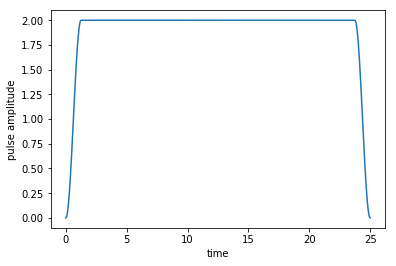

In [14]:
plot_pulse(L[1][1], tlist)

Before optimizing, we solve the equation of motion for the guess field
$\epsilon_{0}(t)$.

In [15]:
guess_dynamics = objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11])

By inspecting the population dynamics of qubit and TLS ground state, we see that
both are oscillating and especially the qubit's ground state population reaches
a maximal value at intermediate times $t < T$. This maximum is indeed the
maximum that is physically possible. However, we want to reach this maximum at
final time $T$ (not before), so the guess field is not doing the right thing so
far.

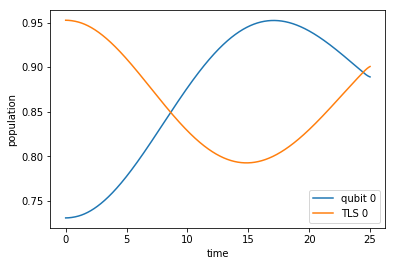

In [16]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, np.array(result.expect[0])+np.array(result.expect[1]),
            label='qubit 0')
    ax.plot(result.times, np.array(result.expect[0])+np.array(result.expect[2]),
            label='TLS 0')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

plot_population(guess_dynamics)

## Optimize


Our optimization target is the ground state $\ket{\Psi_{q}^{\tgt}} = \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our optimization functional reads

\begin{equation}
  F_{re} = 1 -
\Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}
\end{equation}

and we first define `print_qubit_error`, which prints out the
above functional after each iteration.

In [17]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = trace_TLS(state_T)
        taus.append(state_q_T[0,0].real)
    F_re = 1 - np.average(taus)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

In order to minimize the above functional, we need to provide the correct
`chi_constructor` for the Krotov optimization, as it contains all necessary
information. Given our bipartite system and choice of $F_{re}$, the
$\op{\chi}(T)$ reads

\begin{equation}
  \op{\chi}(T) =
  \sum_{k=0,1} a_{k}
\op{\rho}_{q}^{\tgt} \otimes \ket{k}\bra{k}
\end{equation}

with $\{\ket{k}\}$ a
basis for the TLS Hilbert space.

In [18]:
def TLS_onb_trg():
    """Returns the tensor product of qubit target state
    and a basis for the TLS Hilbert space"""
    rho1 = qutip.Qobj(np.kron(rho_q_trg, np.diag([1,0])))
    rho2 = qutip.Qobj(np.kron(rho_q_trg, np.diag([0,1])))
    return [rho1, rho2]

TLS_onb = TLS_onb_trg()

def chis_qubit(states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in states_T:
        chis_i = np.zeros(shape=(4,4), dtype=np.complex_)
        for state_k in TLS_onb:
            a_i_k = krotov.optimize._overlap(state_i_T, state_k)
            chis_i += a_i_k * state_k
        chis.append(qutip.Qobj(chis_i))
    return chis

The following carries out the optimization.

In [19]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        print_qubit_error),
    iter_stop=5)

Iteration 0: 	F = 0.110918
Iteration 1: 	F = 0.105496
Iteration 2: 	F = 0.066806
Iteration 3: 	F = 0.050200
Iteration 4: 	F = 0.049164
Iteration 5: 	F = 0.048533


## Simulate the dynamics of the optimized field

The plot of the optimized field
shows, that the optimization slightly shifts the field such that qubit and TLS
are no longer perfectly in resonance.

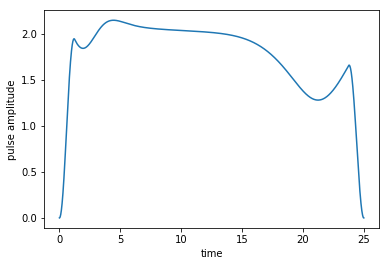

In [20]:
plot_pulse(oct_result.optimized_controls[0], tlist)

This slight shift of qubit and TLS out of resonance delays the population oscillations between
qubit and TLS ground state such that the qubit ground state is maximally
populated at final time $T$.

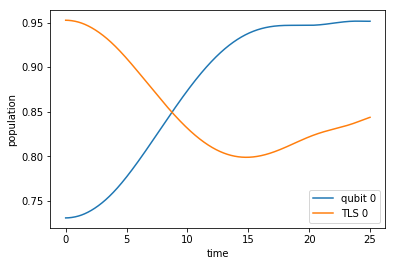

In [21]:
optimized_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11])

plot_population(optimized_dynamics)